[`yolov7`](https://github.com/WongKinYiu/yolov7/tree/main)

[train_aux.py](https://github.com/WongKinYiu/yolov7/blob/main/train_aux.py#L41) training on large images with more complex models

In [1]:
%matplotlib inline

import os
import re
import sys
import yaml
import random

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

seed=0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## slower, more reproducible
#cudnn.benchmark, cudnn.deterministic = False, True
## faster, less reproducible
#cudnn.benchmark, cudnn.deterministic = True, False

In [2]:

%load_ext autoreload
%autoreload 2

sys.path.append('../../../')
from video_processing.yolov7.parameter_parser import parser
from video_processing.yolov7.models.model import Model
from video_processing.yolov7.train.utils import setup_optimizer
from video_processing.yolov7.dataset.coco_dataset import LoadImagesAndLabels
from video_processing.yolov7.utils.general import one_cycle, check_image_size

In [3]:
data_dirpath='D:/data/coco'
result_dirpath='D:/results/yolov7'

argument=f"""
--data-dirpath {data_dirpath}/coco --output-dirpath {result_dirpath} 
--worker 1 --device cpu --batch-size 2 --data coco.yaml --img 1280 1280 --cfg yolov7-w6.yaml
--weights ''  --name yolov7-w6 --hyp hyp.scratch.p6.yaml 
--n-training-data 100 --n-val-data 20 --correct-exif
"""
args=parser.parse_args(argument.split())

In [4]:
device=torch.device('cpu' if not torch.cuda.is_available() or args.device=='cpu' else 'cuda')
print(device, args.batch_size)

cpu 2


In [5]:
if not os.path.isdir(args.output_dirpath):os.makedirs(args.output_dirpath)
args.checkpoint_dirpath=os.path.join(args.output_dirpath, args.checkpoint_dirname)
if not os.path.isdir(args.checkpoint_dirpath): os.makedirs(args.checkpoint_dirpath)

In [6]:
# hyperparameters
with open(args.hyp) as f: hyp=yaml.load(f, Loader=yaml.SafeLoader)
# data
args.is_coco=len(re.findall("coco.yaml$", args.data))>0
print('args.is_coco ', args.is_coco)
with open(args.data) as f: data_dict=yaml.load(f, Loader=yaml.SafeLoader)
# number of classes
nc=1 if args.single_cls else int(data_dict['nc']) 
names=['item'] if args.single_cls and len(data_dict['names'])!=1 else data_dict['names'] # class names
assert len(names)==nc, f'There are {len(names)} class names but {nc} classes' 

args.is_coco  True


In [7]:
# save running
with open(os.path.join(args.output_dirpath, 'hyp.yaml'), 'w') as f: yaml.dump(hyp, f, sort_keys=False)
with open(os.path.join(args.output_dirpath, 'args.yaml'), 'w') as f: yaml.dump(vars(args), f, sort_keys=False)

In [9]:
# define model and optimizers
model=Model(args.cfg, ch=3, nc=nc, anchors=hyp.get('anchors')).to(device)  # it is safer to move model to device first and then create optimizer
optimizer=setup_optimizer(model, learning_rate=hyp['lr0'], momentum=hyp['momentum'], weight_decay=hyp['weight_decay'])
scheduler=torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=one_cycle(1., hyp['lrf'], args.epochs))
start_epoch, best_loss=1, np.inf
if args.resume is not None and os.path.isfile(os.path.join(args.checkpoint_dirpath, args.resume)):
    checkpoint = torch.load(PATH, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    start_epoch = checkpoint['epoch']+1
    best_loss = checkpoint['best_loss']

In IAxDetect nl: 4 na: 3
In IAxDetect anchors: torch.Size([4, 3, 2]) 4x3x2
In IAxDetect anchor_grid: torch.Size([4, 1, 3, 1, 1, 2]) 4x1x3x1x1x2


In [10]:
# check that the image size divisible by stride
max_stride=max(int(model.stride.max()), 32)
assert check_image_size(image_size=args.img_size, stride=max_stride), f'{args.img_size} must be divisible by {max_stride}'


In [11]:
# train/val data loader
train_dataset=LoadImagesAndLabels(data_dirpath=args.data_dirpath, image_paths=data_dict['train'], img_size=args.img_size[0],
                            augment=True, hyp=hyp, n_data=args.n_training_data, correct_exif=args.correct_exif)
val_dataset=LoadImagesAndLabels(data_dirpath=args.data_dirpath, image_paths=data_dict['val'], img_size=args.img_size[0],
                            augment=False, hyp=hyp, n_data=args.n_val_data, correct_exif=args.correct_exif)

train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=args.batch_size, num_workers=1, pin_memory=True, 
                                        collate_fn=LoadImagesAndLabels.collate_fn)
val_loader=torch.utils.data.DataLoader(dataset=val_dataset, batch_size=args.batch_size, num_workers=1, pin_memory=True, 
                                        collate_fn=LoadImagesAndLabels.collate_fn)

In dataset.coco_dataset.__init__ save cache to D:\data\coco\coco\labels\train2017.cache cache_path.is_file() True
In dataset.coco_dataset.__init__ save cache to D:\data\coco\coco\labels\val2017.cache cache_path.is_file() True



 0  boxes  torch.Size([2, 4]), j  0  box  torch.Size([4]), j  1  box  torch.Size([4]),
 1  boxes  torch.Size([2, 4]), j  0  box  torch.Size([4]), j  1  box  torch.Size([4]),
 0  boxes  torch.Size([25, 4]), j  0  box  torch.Size([4]), j  1  box  torch.Size([4]), j  2  box  torch.Size([4]), j  3  box  torch.Size([4]), j  4  box  torch.Size([4]), j  5  box  torch.Size([4]), j  6  box  torch.Size([4]), j  7  box  torch.Size([4]), j  8  box  torch.Size([4]), j  9  box  torch.Size([4]), j  10  box  torch.Size([4]), j  11  box  torch.Size([4]), j  12  box  torch.Size([4]), j  13  box  torch.Size([4]), j  14  box  torch.Size([4]), j  15  box  torch.Size([4]), j  16  box  torch.Size([4]), j  17  box  torch.Size([4]), j  18  box  torch.Size([4]), j  19  box  torch.Size([4]), j  20  box  torch.Size([4]), j  21  box  torch.Size([4]), j  22  box  torch.Size([4]), j  23  box  torch.Size([4]), j  24  box  torch.Size([4]),
 1  boxes  torch.Size([3, 4]), j  0  box  torch.Size([4]), j  1  box  torch.Si

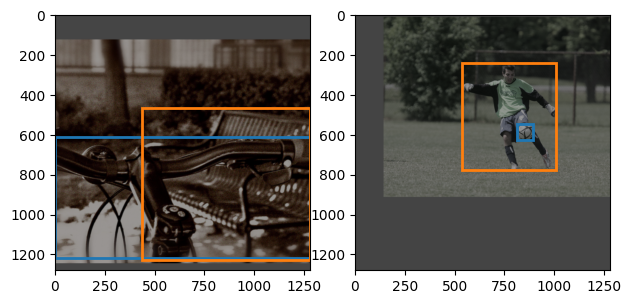

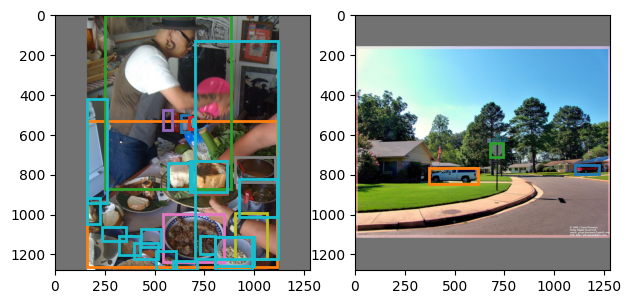

In [13]:
from matplotlib import patches
from video_processing.yolov7.dataset.coords import normalized_xywh2xyxy

cmap = plt.get_cmap('tab10', 10)
imgs, labels, fpath=next(iter(train_loader))
_, ax=plt.subplots(1,imgs.shape[0],figsize=(6,3))
for i, img in enumerate(imgs):
    is_box=labels[:,0]==i # box of this image
    boxes=labels[:,2:][is_box]
    print('\n', i, ' boxes ', boxes.shape, end=',')
    boxes=normalized_xywh2xyxy(boxes,w=img.shape[-1], h=img.shape[1])
    ax[i].imshow(img.permute(1,2,0)) # CxHxW to HxWxC
    for j, box in enumerate(boxes):
        print(' j ', j, ' box ', box.shape, end=',')
        # Create a Rectangle patch
        rect = patches.Rectangle(box[:2], box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=cmap(j), facecolor='none')
        # Add the patch to the Axes
        ax[i].add_patch(rect)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

imgs, labels, fpath=next(iter(val_loader))
_, ax=plt.subplots(1,imgs.shape[0],figsize=(6,3))
for i, img in enumerate(imgs):
    is_box=labels[:,0]==i # box of this image
    boxes=labels[:,2:][is_box]
    print('\n', i, ' boxes ', boxes.shape, end=',')
    boxes=normalized_xywh2xyxy(boxes,w=img.shape[-1], h=img.shape[1])
    ax[i].imshow(img.permute(1,2,0)) # CxHxW to HxWxC
    for j, box in enumerate(boxes):
        print(' j ', j, ' box ', box.shape, end=',')
        # Create a Rectangle patch
        rect = patches.Rectangle(box[:2], box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=cmap(j), facecolor='none')
        # Add the patch to the Axes
        ax[i].add_patch(rect)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

In [20]:
torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'best_loss': best_loss,
            ...
            }, PATH)

80